# 03. PyTorch Computer Vision

**Q**: What is Computer Vision?

**A**: Allows Computers to process visual data

**Q**: What is a Convolutional Neural Network?

**A**: Allows Computers to process visual data


In [1]:
'''
Computer Vision Libraries:
    - torchvision (PyTorch's computer vision library)
    - torchvision.datasets (Get datasets and data loading functions)
    - torchvision.transforms (functions for manipulating images)
    - torch.models (get pre-trained computer vision models)
    - torch.utils.data.DataLoader (Creates a Python iterable over a dataset)
    - torch.utils.data.Dataset (An abstract class representing a dataset)
'''

"\nComputer Vision Libraries:\n    - torchvision (PyTorch's computer vision library)\n    - torchvision.datasets (Get datasets and data loading functions)\n    - torchvision.transforms (functions for manipulating images)\n    - torch.models (get pre-trained computer vision models)\n    - torch.utils.data.DataLoader (Creates a Python iterable over a dataset)\n    - torch.utils.data.Dataset (An abstract class representing a dataset)\n"

In [2]:
# Import all the necessary libraries

import torch
from torch import nn
import torchvision
from torchvision import *
from matplotlib import pyplot as plt

#### 1. Getting a Dataset

In [3]:
''' 
We will be using the FashionMNIST dataset for this tutorial.
    -> FashionMNIST is a dataset of Zalando's article images 
        consisting of 60,000 training examples and 10,000 test examples.
'''

# Load the FashionMNIST dataset
# Load the training set
train_data = datasets.FashionMNIST(
    root = 'data', # Location where the data will be downloaded
    train = True, # Do we want the training set?
    download = True, # Should the data be downloaded?
    transform = transforms.ToTensor(), # how do we want to transform the data?
    target_transform = None # how do we want to transform the labels/targets?
)

# Load the test set
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

'''
A little bit about the FashionMNIST dataset:
    - The FashionMNIST dataset consists of 60,000 training examples and 10,000 test examples.
    - Each example is a 28x28 grayscale image.
    - Each example is associated with a label from 10 classes.
    - The dataset is split into two parts: training and test.
    - The training set consists of 60,000 examples and the test set consists of 10,000 examples.
    - The labels are as follows:
        0: T-shirt/top
        1: Trouser
        2: Pullover
        3: Dress
        4: Coat
        5: Sandal
        6: Shirt
        7: Sneaker
        8: Bag
        9: Ankle boot
'''

train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28]) 9


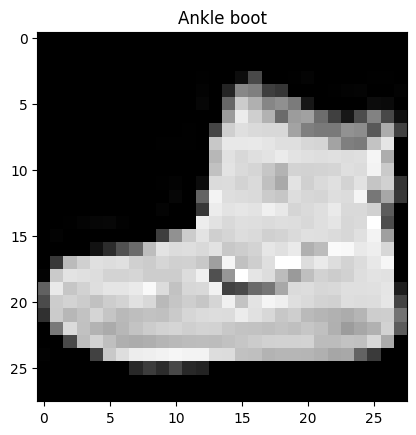

In [44]:
image, label = train_data[0]
print(image.shape, label)
plt.title(train_data.classes[label])
plt.imshow(image.squeeze(), cmap='gray')


#### 2. Preparing the Dataset

DataLoader turns our dataset into a Python Iterable, changes our dataset into batches

Why do we do this?
1. It is computationally efficient.
2. It gives our neural network more chances to update its gradients per epoch.

In [5]:
from torch.utils.data import DataLoader

# Setup the batch size Hyperparameter
BATCH_SIZE = 32

'''
What is the purpose of storing the data into batches?

    - Controls Memory Management:
        - Instead of processing the entire dataset at once, the data is split 
            into smaller chunks called batches.
            - Smaller batch sizes use less memory because fewer samples are loaded 
                and processed at a time.
            - Larger batch sizes may require more memory but process data faster 
                because fewer iterations are needed.

    - Affects Training Speed and Model Performance:
        - Small batches: More updates to the model per epoch but can be slower overall.
        - Large batches: Faster overall but may generalize poorly to new data.
'''

# Turn dataset into iterables
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

# Lets see what we made
print(f"Dataloaders: {train_dataloader}, {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)}; Batch size: {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)}; Batch size: {BATCH_SIZE}")

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x000001E78A80EC00>, <torch.utils.data.dataloader.DataLoader object at 0x000001E78A862600>
Length of train_dataloader: 1875; Batch size: 32
Length of test_dataloader: 313; Batch size: 32


In [ ]:
# See whats inside of the dataloader

'''
On one iterable of the dataloader, we have a tuple of two elements:
    - The first element is a tensor of images
    - The second element is a tensor of labels

    - So keep in mind the batch size was initialized as 32, so there are 32 images and 
        32 labels in each batch.
    
    Each Iterable contains a tuple of 32 images and 32 Labels
        -> Each image is a tensor of shape (1, 28, 28)
            -> First dimension is the number of channels (1 for grayscale)
            -> Second and third dimensions are the height and width of the image
        -> Each label is a tensor of shape (32)
            -> A 1D tensor of length 32 (32 Labels for the 32 images)
'''
images, labels = next(iter(train_dataloader))
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

#### 3. Building a Base Model
A Baseline-Model is a simple model that can be improved on with subsequent experiments 

In [7]:
torch.manual_seed(42)

# Create a Flatten Layer
flatten_model = torch.nn.Flatten()

'''
What is a Flatten Layer?
    -> A Flatten layer is used to flatten the input tensor into a 1D tensor.
    -> It is used to convert the 2D input tensor of shape (N, C, H, W) 
        into a 1D tensor of shape (N, C*H*W).
'''

class FashionMNSTModelV0(nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
        super(FashionMNSTModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

modelV0 = FashionMNSTModelV0(
    input_shape=28*28, # Size of the image
    output_shape=len(train_data.classes), # One for every class
    hidden_units=10) # How many units in the hidden layer?

#### 3.1 Setup Loss and Optimizer Function
* Loss Function: Since we are working with Multi-Class Data, we will be using 
`nn.CrossEntropyLoss()`
* Optimizer: Our Optimizer will be `torch.optim.SGD` (Stohastic Gradient Descent)
* Evaluation Metric: Since we are working with a Classification model, its best to use an Accuracy Function to test our model

In [8]:
# Set up Loss Function
loss_fn = nn.CrossEntropyLoss()

# Set up Optimizer
optimizer = torch.optim.SGD(params=modelV0.parameters(), lr=0.1)

# Accuracy function
def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


#### 3.2 Creating a Function to time our experiments
Two things we want to keep track of during Machine Learning
1. Model's Performance (Loss and Accuracy values)
2. How fast it runs 

In [9]:
from timeit import default_timer as timer
def print_train_time(start:float, end:float):
    print(f"Training Time: {end - start:.3f} seconds")

#### 3.3 Creating our Training and Testing Loops
1. Loop through data (epochs)
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out whats happening
5. Time it all

In [10]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        modelV0.train() 
        # 1. Forward pass
        y_pred = modelV0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    modelV0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = modelV0(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += calculate_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_modelV0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu)

c:\Users\Mural\Github Projects\Learning-Pytorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:06<00:12,  6.36s/it]


Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:12<00:06,  6.47s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:19<00:00,  6.54s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Training Time: 19.621 seconds


#### 4. Make Predictions and get ModelV0 Results

In [11]:
torch.manual_seed(42)

def eval_model(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
    loss_fn:torch.nn.Module, calculate_accuracy):

    ''' Returns Results of the Model predicting on the Dataloader '''
    model.eval()
    loss, acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            # Make Predictions
            y_pred = model(X)

            # Accumulate Loss and Accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += calculate_accuracy(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale Loss and Accuracy values to find average per batch
        loss /= len(dataloader)
        acc /= len(dataloader)
    
    return {"Model Name: ": model,"loss": loss, "accuracy": acc}

# Now lets evaluate the model
results = eval_model(model=modelV0, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn, 
    calculate_accuracy=calculate_accuracy)

print(results)

{'Model Name: ': FashionMNSTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
), 'loss': tensor(0.4766), 'accuracy': 83.42651757188499}


#### 5. Building a Better Model with Non-Linear Layers

In [12]:
class FashionMNSTModelV1(nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # Flatten input to a single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

modelV1 = FashionMNSTModelV1(
    input_shape=28*28, # Size of the image
    output_shape=len(train_data.classes), # One for every class
    hidden_units=10) # How many units in the hidden layer? (Arbitrary)

# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss() # <- Measures how wrong our model is
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.1) # Updates our model parameters based off of the learning rate

#### 5.1 Functionizing Testing and Training

In [13]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               calculate_accuracy
               ):
    train_loss, train_acc = 0, 0
     # put model in training mode
    for batch, (X, y) in enumerate(data_loader):
        model.train()     
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += calculate_accuracy(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy
              ):
    test_loss, test_acc = 0, 0
    
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += calculate_accuracy(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [14]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_step(model=modelV1, 
               data_loader=train_dataloader, 
               loss_fn=loss_fn, 
               optimizer=optimizer, 
               calculate_accuracy=calculate_accuracy 
               )

    ### Testing
    test_step(data_loader=test_dataloader, 
              model=modelV1, 
              loss_fn=loss_fn, 
              calculate_accuracy=calculate_accuracy
              )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.98248 | Train accuracy: 65.06%


 33%|███▎      | 1/3 [00:06<00:12,  6.36s/it]

Test loss: 0.76060 | Test accuracy: 72.80%

Epoch: 1
-------
Train loss: 0.70374 | Train accuracy: 74.43%


 67%|██████▋   | 2/3 [00:13<00:06,  6.71s/it]

Test loss: 0.71959 | Test accuracy: 73.53%

Epoch: 2
-------
Train loss: 0.67371 | Train accuracy: 75.37%


100%|██████████| 3/3 [00:20<00:00,  6.74s/it]

Test loss: 0.69469 | Test accuracy: 74.71%



#### 6. Creating a Convolutional Neural Network
https://poloclub.github.io/cnn-explainer/

In [ ]:
'''
As seen above, we have created 2 models, modelV0 and modelV1. 

modelV0 uses strictly Linear Layers while
modelV1 uses Linear and ReLU activation functions, Non-Linear Layers.

modelV0 produced better results than modelV1 but both arent great.

We will now create a model that uses Convolutional Neural Networks (CNNs) 
to see if we can get better results.
'''

class FashionMNSTModelV2(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x



#### 6.1 Understanding Our Model 
Lets understand how the Convolutional Neural Network works:
* A Convolutional Neural Network (CNN) is a type of computer program designed to recognize patterns, especially in images.

We start by defining the Convolutional Layers: 
* self.conv_block1 and self.conv_block2
* Now lets break down what is inside the Convolutional Layers:
* Each Convolutional Layer consists of:
* Conv2d: This is the convolutional layer that performs the convolution operation on the input image.

-> What is the convolution operation?
* The convolution operation is the process of applying a filter to an image. 
    * For example, a filter can be a 3x3 matrix that is applied to the image.
* The filter is applied to the image by sliding it across the image and computing the 
    * dot product of the filter and the image.
* The result of the dot product is the output of the convolution operation.

-> The Conv2d layer takes the following arguments:
* in_channels: The number of input channels to the convolutional layer.
* out_channels: The number of output channels from the convolutional layer.
* kernel_size: The size of the filter that is applied to the image.
    * Choosing this hyperparameter has a massive impact on the image classification
        * Selecting a Small Kernel Size will be able to extract larger amounts of inforation containing highly local features
        * Selecting a Large Kernel Size extracts less information, leading to faster reduction in layer dimensions. Leads to worse performance but they are more suited to extract features that are larger
* stride: Indicates how many pixels the kernel should be shifted over at a time.
* padding: Necessary when the kernel extends beyond the activation map. Padding conserves data at the border of activation maps, leading to better performance

* ReLU: The activation function that introduces non-linearity into the model.
* MaxPool2d: The pooling layer that reduces the spatial dimensions of the image.
    * The MaxPool2d layer takes the following arguments:
        * kernel_size: The size of the pooling window.
           * We include this as an argument to the MaxPool2d layer to specify the size of the pooling window.


#### 7. Testing our CNN

In [45]:
# # Create a batch of test images
# torch_random_image = next(iter(test_dataloader))[0][0]
modelV2 = FashionMNSTModelV2(
    input_shape=1, # Size of the image
    hidden_units=10, # Number of hidden units
    output_shape=len(train_data.classes)) # Number of output units
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV2.parameters(), lr=0.01)

# modelV2(torch_random_image.unsqueeze(dim=1))

modelV2_results = eval_model(model=modelV2,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    calculate_accuracy=calculate_accuracy)

print(modelV2_results)

{'Model Name: ': FashionMNSTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
), 'loss': tensor(2.3047), 'accuracy': 10.0}


#### 7.1 Training and Testing our Model

Now that we have seen that our model can produce an output, it supposedly works, lets now train and test with our data

In [46]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Train and test the model
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    ''' Training Loop '''
    train_step(model=modelV2,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                calculate_accuracy=calculate_accuracy)
    
    ''' Testing Loop '''
    test_step(data_loader=test_dataloader,
                model=modelV2,
                loss_fn=loss_fn,
                calculate_accuracy=calculate_accuracy)

train_time_end_on_cpu = timer()
total_train_time_modelV2 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.69822 | Train accuracy: 35.62%


 10%|█         | 1/10 [00:35<05:16, 35.20s/it]

Test loss: 0.72525 | Test accuracy: 73.10%

Epoch: 1
-------
Train loss: 0.62323 | Train accuracy: 77.75%


 20%|██        | 2/10 [01:03<04:11, 31.38s/it]

Test loss: 0.54494 | Test accuracy: 79.62%

Epoch: 2
-------
Train loss: 0.48053 | Train accuracy: 82.79%


 30%|███       | 3/10 [01:31<03:26, 29.48s/it]

Test loss: 0.45826 | Test accuracy: 83.99%

Epoch: 3
-------
Train loss: 0.42857 | Train accuracy: 84.47%


 40%|████      | 4/10 [01:59<02:54, 29.12s/it]

Test loss: 0.42261 | Test accuracy: 85.17%

Epoch: 4
-------
Train loss: 0.39884 | Train accuracy: 85.77%


 50%|█████     | 5/10 [02:28<02:24, 28.87s/it]

Test loss: 0.40662 | Test accuracy: 85.85%

Epoch: 5
-------
Train loss: 0.37675 | Train accuracy: 86.55%


 60%|██████    | 6/10 [02:56<01:55, 28.83s/it]

Test loss: 0.38991 | Test accuracy: 86.17%

Epoch: 6
-------
Train loss: 0.36046 | Train accuracy: 87.11%


 70%|███████   | 7/10 [03:30<01:31, 30.34s/it]

Test loss: 0.38580 | Test accuracy: 86.49%

Epoch: 7
-------
Train loss: 0.34870 | Train accuracy: 87.46%


 80%|████████  | 8/10 [06:24<02:31, 76.00s/it]

Test loss: 0.36214 | Test accuracy: 87.36%

Epoch: 8
-------
Train loss: 0.33872 | Train accuracy: 87.89%


 90%|█████████ | 9/10 [06:56<01:02, 62.36s/it]

Test loss: 0.35765 | Test accuracy: 87.26%

Epoch: 9
-------
Train loss: 0.33058 | Train accuracy: 88.14%


100%|██████████| 10/10 [07:28<00:00, 44.87s/it]

Test loss: 0.36153 | Test accuracy: 87.01%

Training Time: 448.671 seconds


#### 8. Make and Evaluate Random Predictions with our Best Model

In [54]:
''' Lets make a function to make predictions for the model '''

def make_predictions(model:torch.nn.Module, data: list):
    pred_probs = []

    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (Add a Batch Dimension and pass it to the 
            # target model)
            sample = torch.unsqueeze(sample, dim=0)

            # Forward Pass for the Model (Model outputs raw logits)
            pred_logit = model(sample)

            # Get Prediction Probability (Logits -> Probabilities)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Append the prediction probabilities to the list
            pred_probs.append(pred_prob)

    return torch.stack(pred_probs)

import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), # Get a random sample from the test dataset
 k=9): # Number of samples to get
    test_samples.append(sample)
    test_labels.append(label)

# view the first sample shape
print(test_samples[0].shape)

torch.Size([1, 28, 28])


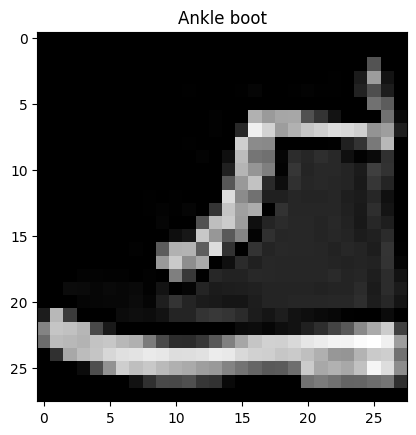

In [37]:
def plot_sample(sample, label):
    plt.imshow(sample.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])

# Plot the first sample
plot_sample(test_samples[0], test_labels[0])

tensor([[4.8205e-08, 2.5666e-09, 2.1131e-08, 7.2656e-07, 1.6030e-07, 4.1143e-02,
         4.9359e-07, 1.4962e-05, 4.0771e-04, 9.5843e-01],
        [1.0429e-06, 9.5016e-07, 2.5998e-03, 1.4569e-08, 9.9635e-01, 2.0053e-09,
         9.8848e-04, 1.6231e-12, 6.1437e-05, 3.2129e-09]])


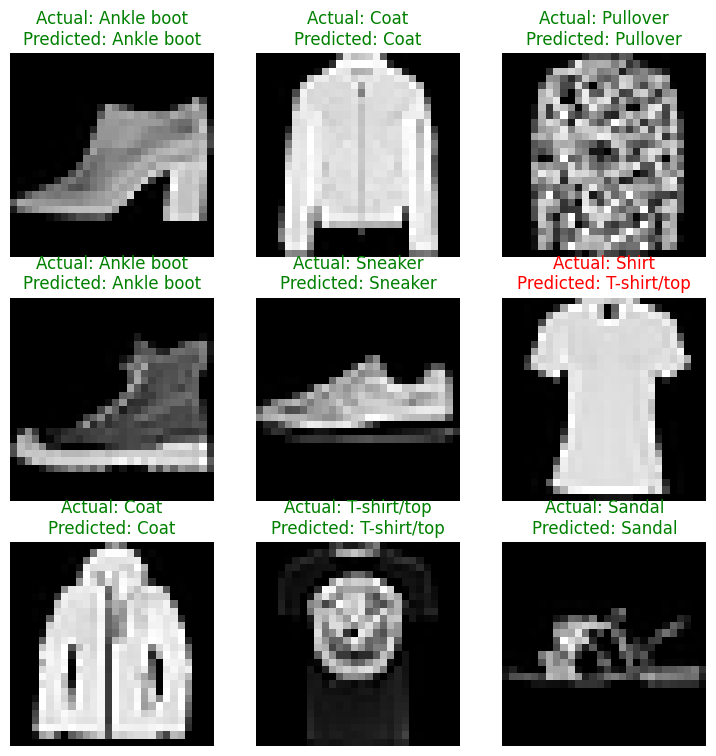

In [55]:
# Make Predictions
pred_probs = make_predictions(model=modelV2, data=test_samples)

# view the first two prediction probabilities
print(pred_probs[:2])

# convert the prediction probabilities to predicted labels
pred_classes = pred_probs.argmax(dim=1)

# Plot the predictions
plt.figure(figsize=(9, 9))
nrows = ncols = 3
for i, sample in enumerate(test_samples):
    
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')

    # Lets change the titles to be green if the predicted == actual, 
    # and red if not
    if test_labels[i] == pred_classes[i]:
        plt.title(f"Actual: {train_data.classes[test_labels[i]]}\nPredicted: {train_data.classes[pred_classes[i]]}", 
                  color='green')
    else:
        plt.title(f"Actual: {train_data.classes[test_labels[i]]}\nPredicted: {train_data.classes[pred_classes[i]]}", 
                  color='red')
    plt.axis('off')

#### 9. Making a Confusion Matrix
Our modelV2 is nearly at 100% accurate but it still gets a few guesses wrong. Enter the Confusion Matrix

**Confusion Matrix**: a table that is used to define the performance of a classification algorithm

Steps for Further Evaluation:
1. Make Predictions with our trained model on the test dataset
2. Make a Confusion Matrix
3. Plot Confusion Matrix using `mixtend.plotting.plot_confusion_matrix()`

In [57]:
# Make Predictions
y_preds = []
modelV2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Predictions"):
        # 1. Forward pass
        y_logits = modelV2(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred)

# Convert the predictions to a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making Predictions: 100%|██████████| 313/313 [00:02<00:00, 121.13it/s]


tensor([9, 2, 1,  ..., 8, 3, 8])

In [71]:
# Plot the confusion matrix
import torchmetrics
from torchmetrics import ConfusionMatrix

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

class_names = train_data.classes

# 2. Set up Confusion Matrix
confusionMatrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusionMatrix_Tensor = confusionMatrix(preds=y_pred_tensor, target=test_data.targets)

confusionMatrix_Tensor

tensor([[508,   5,  44, 131,  10,   0, 288,   0,  14,   0],
        [ 17, 800,  10, 151,  17,   0,   4,   0,   1,   0],
        [ 12,   8, 754,  27, 116,   0,  71,   0,  12,   0],
        [ 31,  12,  19, 874,  29,   0,  24,   0,  11,   0],
        [  5,   6, 157,  70, 646,   0,  98,   0,  18,   0],
        [  6,   0,   1,  10,   1, 774,   4,  82,  97,  25],
        [ 72,   4, 122,  88,  95,   0, 598,   0,  21,   0],
        [  1,   0,   0,   0,   0,  56,   1, 857,  30,  55],
        [ 10,   2,   7,  17,  10,   4,  20,   6, 923,   1],
        [  0,   0,   0,   2,   0,  48,   4, 102,  37, 807]])

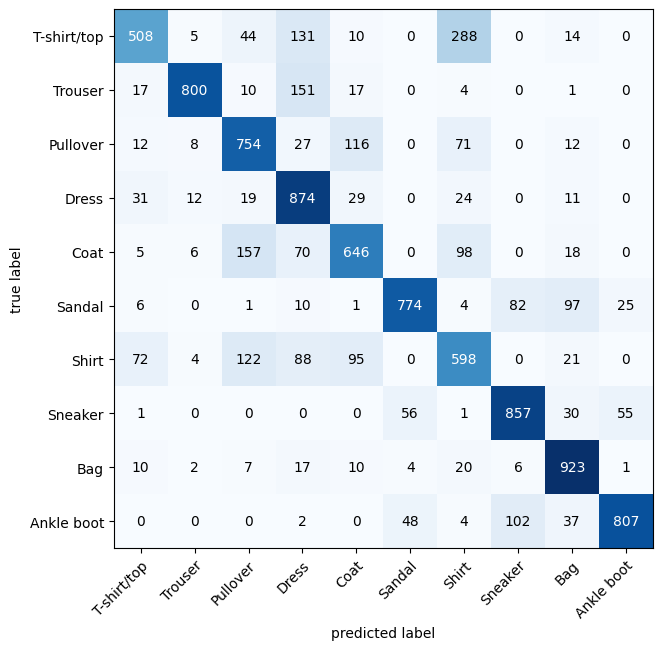

In [72]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)